In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import mne
from scipy.interpolate import griddata
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
import mne
from sklearn.inspection import permutation_importance

In [2]:
# === Load Data ===
X_real_1 = np.load('../data/real_movement_class_1.npy')
X_real_2 = np.load('../data/real_movement_class_2.npy')
X_imag_1 = np.load('../data/imagined_movement_class_1.npy')
X_imag_2 = np.load('../data/imagined_movement_class_2.npy')

X_real_1 = X_real_1.T
X_real_2 = X_real_2.T
X_imag_1 = X_imag_1.T
X_imag_2 = X_imag_2.T

# === Prepare Labels ===
y_real = np.concatenate([np.zeros(X_real_1.shape[0]), np.ones(X_real_2.shape[0])])
y_imag = np.concatenate([np.zeros(X_imag_1.shape[0]), np.ones(X_imag_2.shape[0])])

# === Combine and Normalize ===
X_real = StandardScaler().fit_transform(np.concatenate([X_real_1, X_real_2]))
X_imag = StandardScaler().fit_transform(np.concatenate([X_imag_1, X_imag_2]))

## Imagined data

In [3]:
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X_imag)

/Users/wanghley/Workspace/Projects/neuromappr/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_imag, y_imag, test_size=0.2, stratify=y_imag)

In [5]:
# === Define meshgrid for visualization ===
def create_meshgrid(X, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))

In [6]:
def plot_decision_surface_umap(X_2d, y, clf, title, ax, X_highdim):
    xx, yy = create_meshgrid(X_2d)
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Approximate 204D vectors from UMAP neighbors
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(X_2d)
    _, indices = nn.kneighbors(mesh_points)
    highdim_mesh = X_highdim[indices.flatten()]

    # Get decision function scores for smooth visualization
    Z = clf.predict_proba(highdim_mesh)[:, 1]
    Z = Z.reshape(xx.shape)

    # Plot heatmap with contour and colorbar
    contour = ax.contourf(xx, yy, Z, levels=200, cmap='coolwarm', alpha=0.8)
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=30)
    ax.set_title(title)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Decision Score")


In [7]:
alpha = 10
C = 1/alpha
kernels = ['linear', 'poly', 'rbf', 'sigmoid']


Kernel: linear
Accuracy: 0.8958333333333334
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.79      0.88        24
         1.0       0.83      1.00      0.91        24

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.89        48
weighted avg       0.91      0.90      0.89        48


Kernel: poly
Accuracy: 0.6875
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.92      0.75        24
         1.0       0.85      0.46      0.59        24

    accuracy                           0.69        48
   macro avg       0.74      0.69      0.67        48
weighted avg       0.74      0.69      0.67        48


Kernel: rbf
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.67      0.78        24
         1.0       0.74      0.96      0.84        24

    

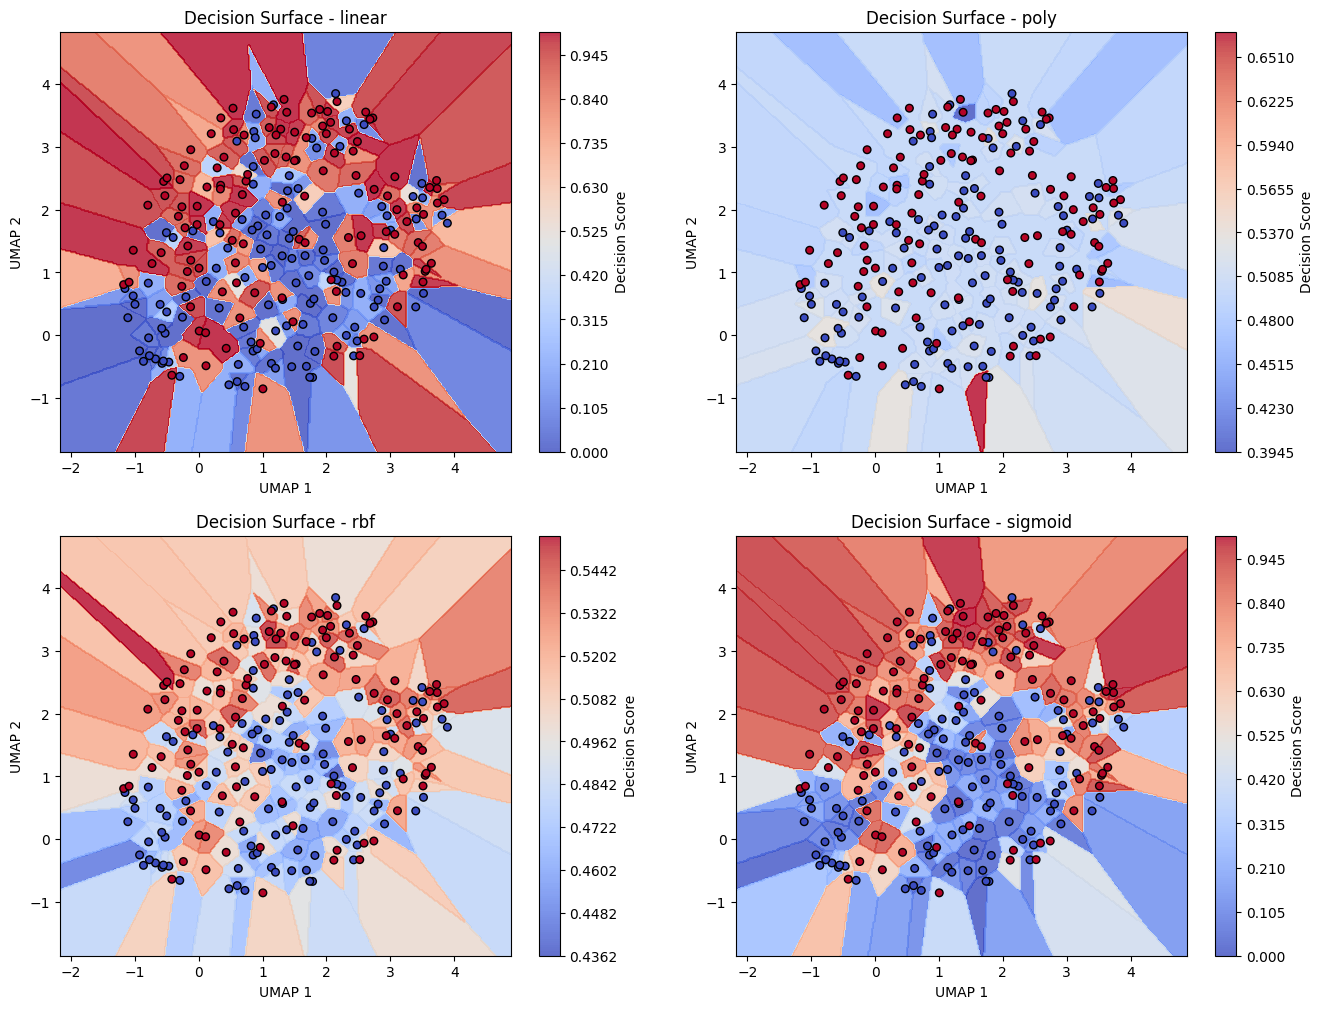

In [8]:
ig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i, kernel in enumerate(kernels):
    clf = SVC(kernel=kernel, C=C, probability=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nKernel: {kernel}")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot decision surface in UMAP-projected 2D space
    plot_decision_surface_umap(X_umap, y_imag, clf, f"Decision Surface - {kernel}", axs[i], X_imag)

In [9]:
# === Load electrode positions ===
coords = pd.read_csv("../data/BCIsensor_xy.csv", header=None).values
coords_scaled = coords / np.max(np.abs(coords))  # normalize for mne
coords_3d = np.hstack([coords_scaled, np.zeros((coords.shape[0], 1))])

In [10]:
electrode_names = [f"e{i}" for i in range(1, 103)]
info = mne.create_info(ch_names=electrode_names, sfreq=100, ch_types='eeg')
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(electrode_names, coords_3d)), coord_frame='head')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, ...
 chs: 102 EEG
 custom_ref_applied: False
 dig: 105 items (3 Cardinal, 102 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 102
 projs: []
 sfreq: 100.0 Hz
>

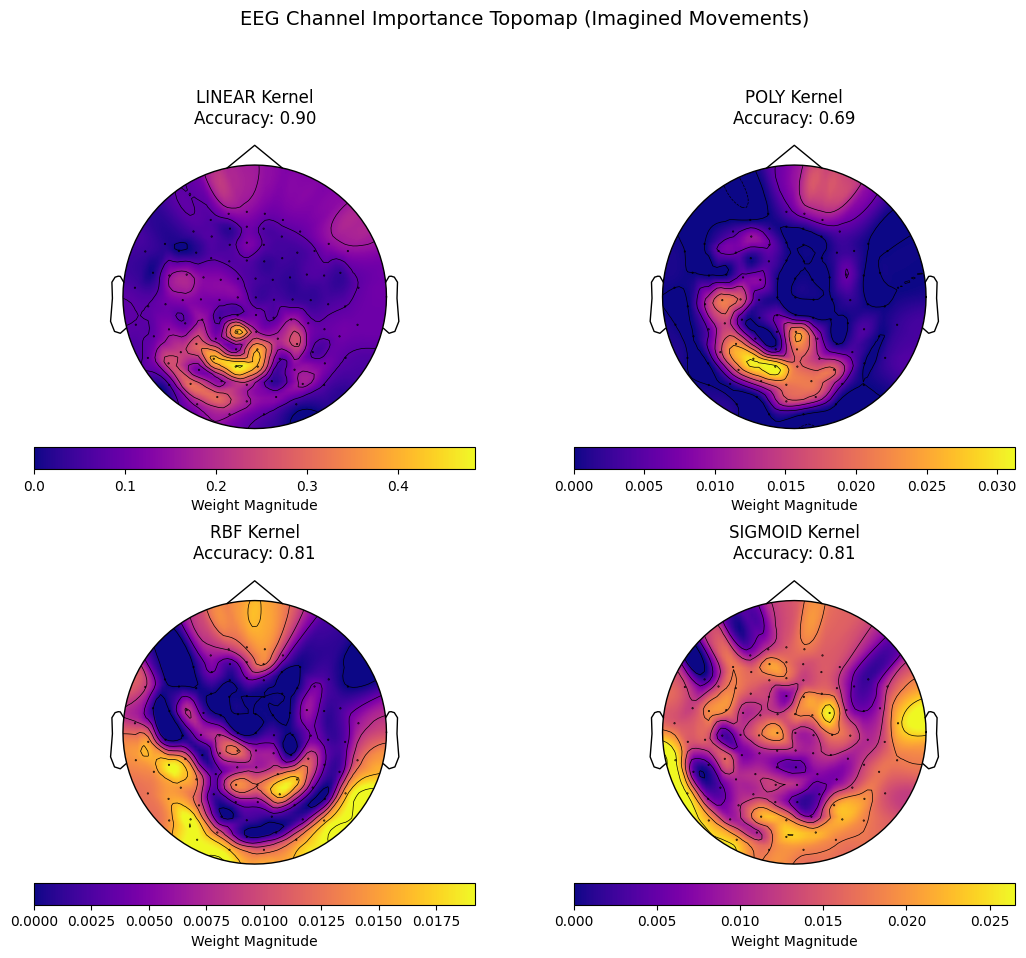

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, kernel in enumerate(kernels):
    clf = SVC(kernel=kernel, C=C, probability=True)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    
    if kernel == 'linear':
        W = clf.coef_.flatten()  # shape (204,)
    else:
        # Use permutation importance for non-linear kernels
        result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        W = result.importances_mean  # shape (204,)
    
    # Aggregate Ex/Ey pair magnitudes → 102 values
    W_x = W[::2]
    W_y = W[1::2]
    W_mag = np.sqrt(W_x**2 + W_y**2)

    # === Plot topomap ===
    ax = axs[i]
    im, _ = mne.viz.plot_topomap(
        W_mag, coords_scaled, axes=ax, cmap='plasma',
        sphere=(0, 0, 0, 1.1), show=False,
    )
    ax.set_title(f"{kernel.upper()} Kernel\nAccuracy: {acc:.2f}")
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.7, pad=0.05)
    cbar.set_label("Weight Magnitude")

plt.suptitle("EEG Channel Importance Topomap (Imagined Movements)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../figures/svm_topomaps_all_kernels.png", dpi=300)
plt.show()


## Real data